In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, mean_absolute_error

import sys
sys.path.append('/opt/homebrew/lib/python3.10/site-packages')

import xgboost as xgb


In [7]:
df = pd.read_csv('./Resources/gtt_results.csv')
df.head()


,id,group,sex,bodyweight,timepoint,t0,t15,t30,t60,t90,t120
0,F208,WT,F,22.8,0,122,194,196.0,188.0,186.0,189.0
1,F039,CLOCK,F,26.7,0,188,165,355.0,596.0,218.0,206.0
2,F014,WT,F,25.1,0,182,289,240.0,219.0,205.0,231.0
3,F081,CLOCK,F,26.1,0,183,266,206.0,214.0,246.0,168.0
4,F051,WT,F,29.8,0,141,199,200.0,171.0,181.0,145.0


In [8]:
df.dropna(axis='rows', inplace=True)


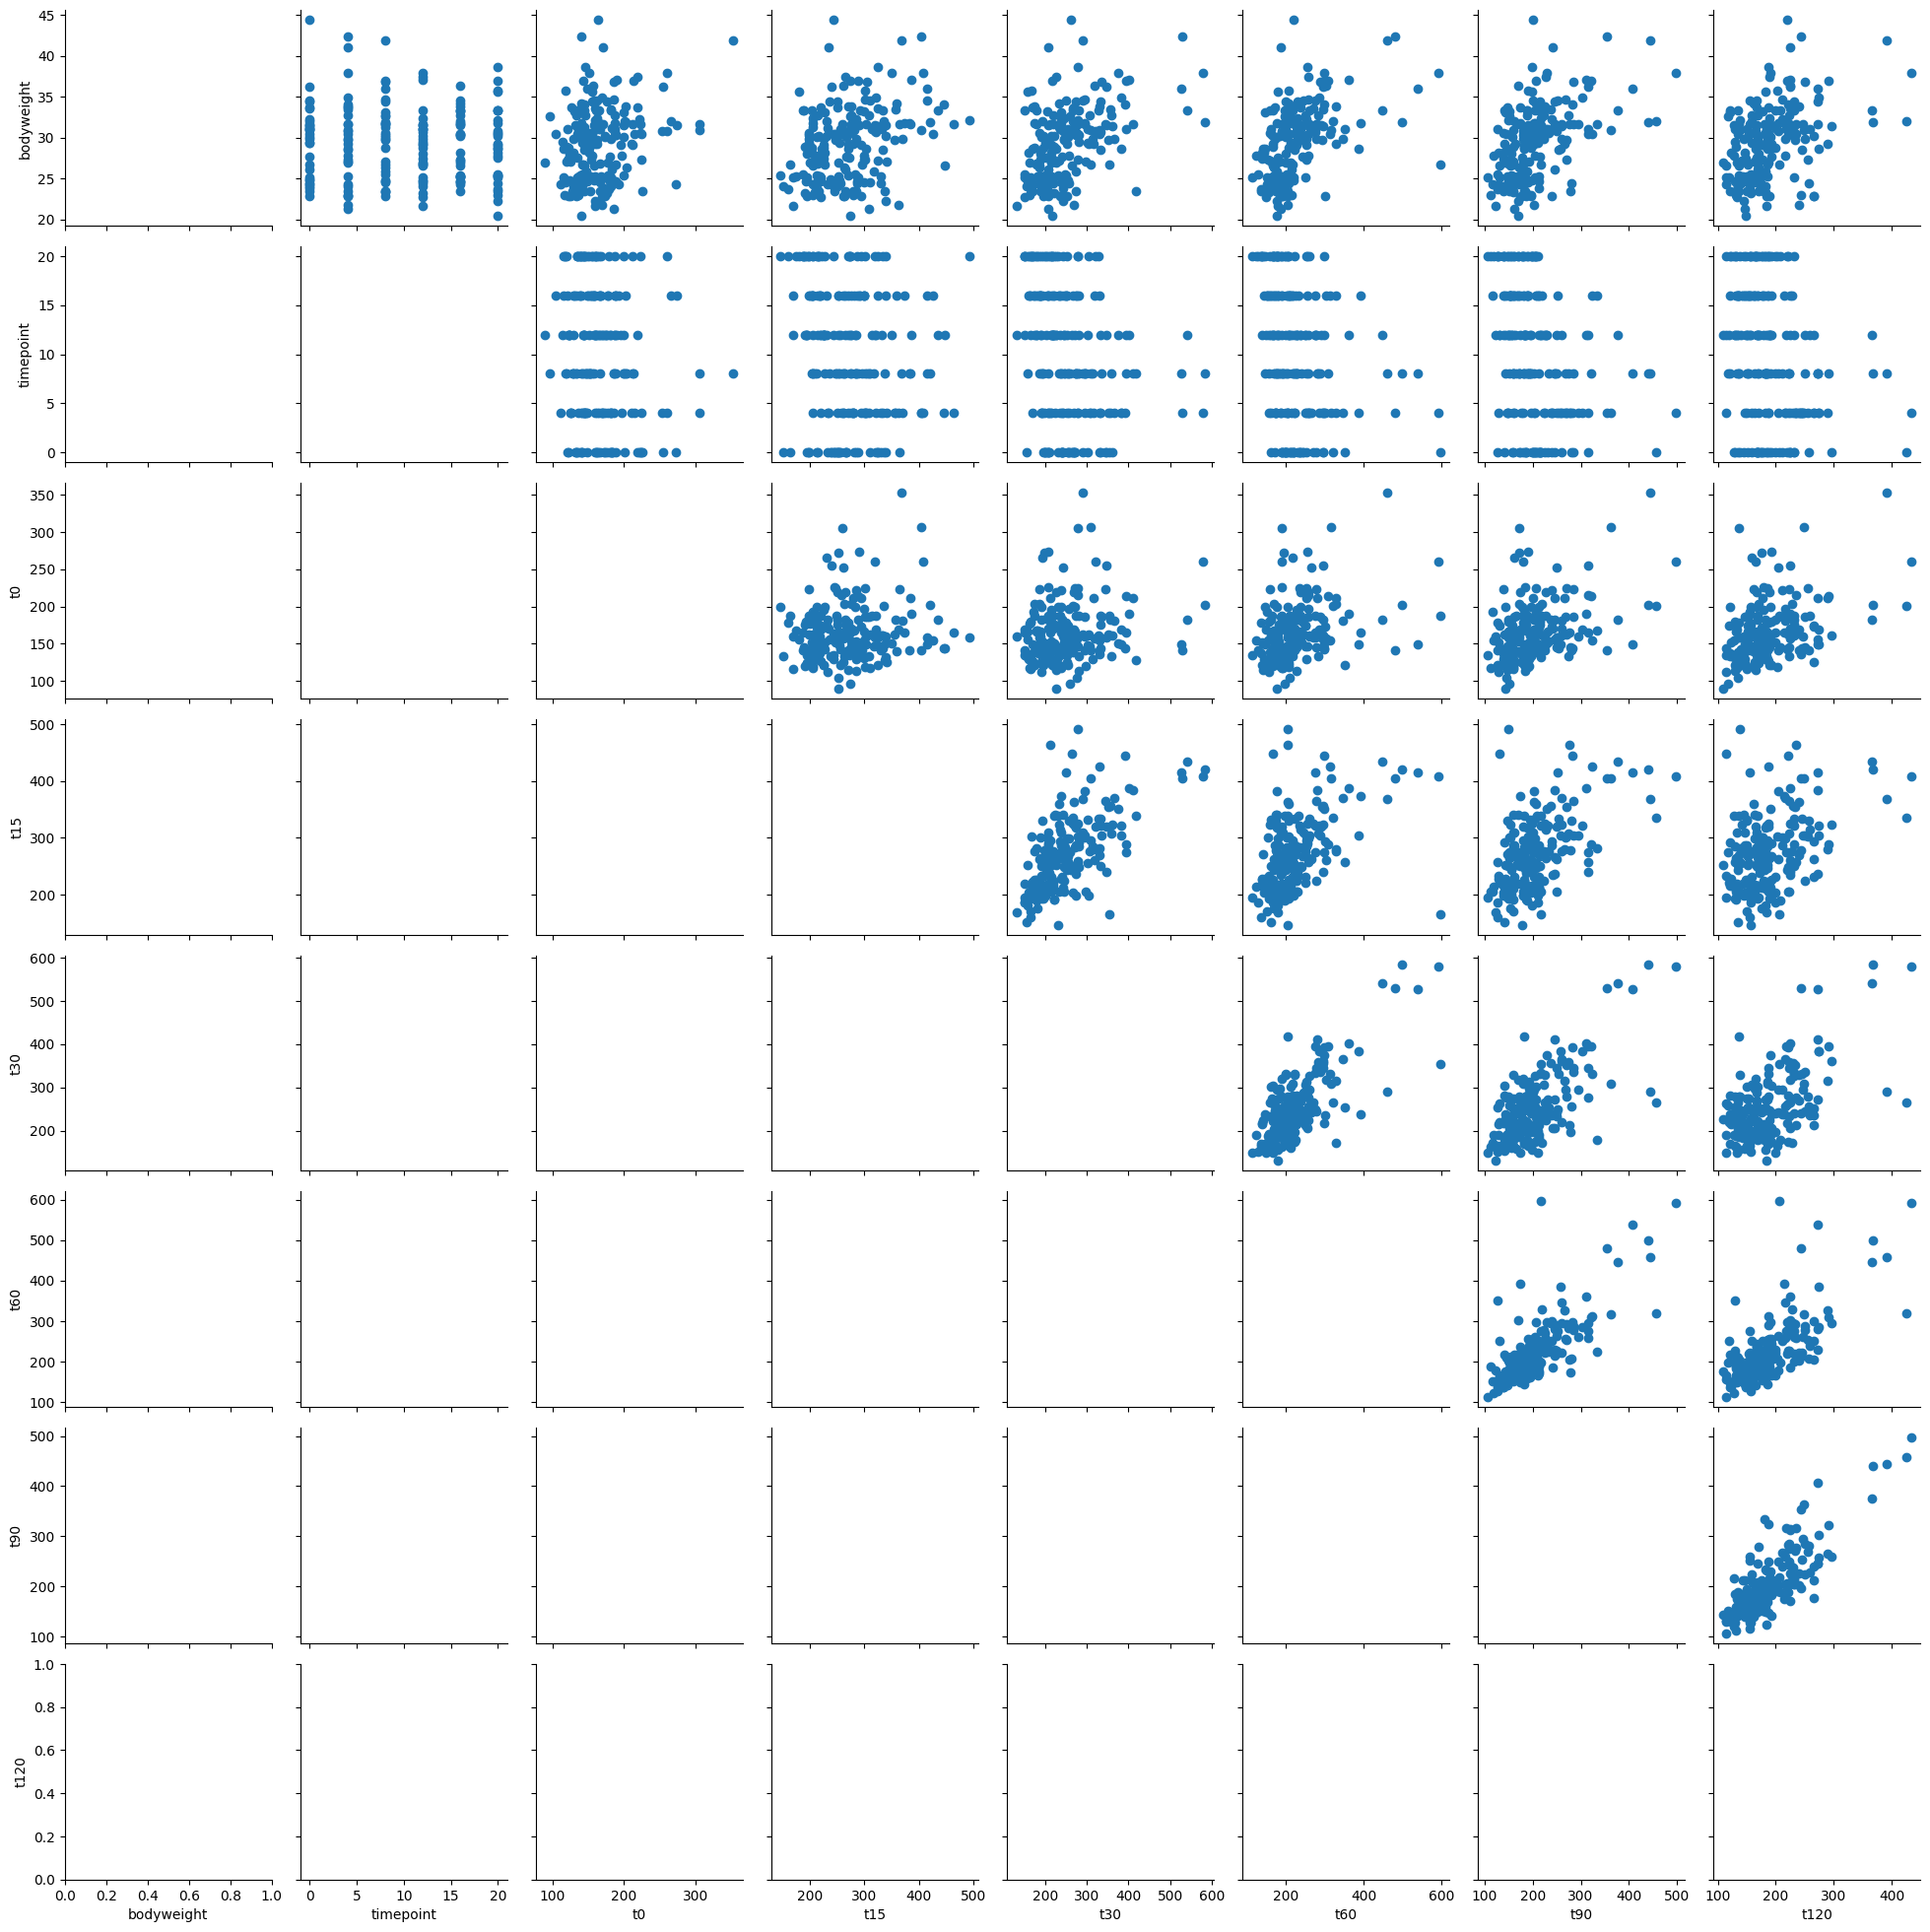

In [9]:
import seaborn

seaborn.PairGrid(df).map_upper(plt.scatter)

In [11]:
#Create data frames for each prediction
df_group = df[['group', 'bodyweight', 'timepoint', 't0', 't15', 't30', 't60', 't90', 't120']]
df_sex = df[['sex', 'bodyweight', 'timepoint', 't0', 't15', 't30', 't60', 't90', 't120']]

## Unsupervised model to identify any clusters

In [12]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[['bodyweight', 'timepoint', 't0', 't15', 't30', 't60', 't90', 't120']])
scaled_data

array([[-1.44657587e+00, -1.45839466e+00, -1.12304124e+00, ...,
        -4.91653697e-01, -2.99455526e-01, -2.02903271e-03],
       [-5.81903774e-01, -1.45839466e+00,  5.60719212e-01, ...,
         4.77481906e+00,  1.90052946e-01,  3.11698072e-01],
       [-9.36641044e-01, -1.45839466e+00,  4.07650080e-01, ...,
        -9.15050317e-02, -8.80987106e-03,  7.73061462e-01],
       ...,
       [-5.45571063e-03,  1.46758622e+00, -7.70688388e-02, ...,
        -7.62722147e-01, -9.87826815e-01,  5.33345741e-02],
       [ 2.60597242e-01,  1.46758622e+00, -7.91391455e-01, ...,
        -3.62573482e-01, -1.31186989e-01, -1.68119853e-01],
       [-4.97978694e-02,  1.46758622e+00,  1.17299574e+00, ...,
         3.34459676e-01, -6.99984301e-02, -2.23483460e-01]])

In [13]:
# Initialize PCA model
pca = PCA(n_components=0.90)

# Get two principal components for the iris data.
pca = pca.fit_transform(scaled_data)

#Convert to pd dataframe
pca = pd.DataFrame(pca)
pca.head()

,0,1,2,3,4
0,-1.424693,1.078793,-1.815320,0.666332,-0.871765
1,2.484678,1.403529,-0.808650,0.939940,-1.699220
2,0.378834,1.317219,-1.178750,-0.403195,-0.101924
3,-0.060820,1.392783,-0.976927,-0.134919,0.317033
4,-1.259134,0.839754,-0.993108,1.355011,0.547998


1


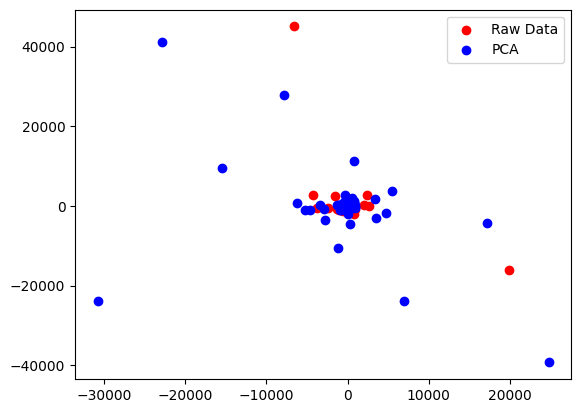

In [15]:
for p in np.arange(1,100,2):

    tsne = TSNE(learning_rate=750, perplexity=p)
    tsne_features_pca = tsne.fit_transform(pca)
    tsne_features_raw = tsne.fit_transform(scaled_data)
    clear_output(wait=True)
    
    print(p)
    plt.scatter(tsne_features_raw[:,0], tsne_features_raw[:,1], c='red')
    plt.scatter(tsne_features_pca[:,0], tsne_features_pca[:,1], c='blue')
    plt.legend(['Raw Data', 'PCA'])
    plt.show()

In [16]:
#t-SNE analysis
tsne = TSNE(learning_rate=750, perplexity=22)

tsne_features_pca = tsne.fit_transform(pca)
tsne_features_raw = tsne.fit_transform(scaled_data)

print(tsne_features_pca.shape)
print(tsne_features_raw.shape)

(191, 2)
(191, 2)


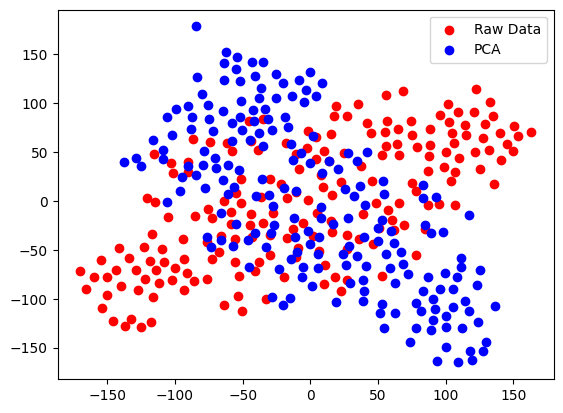

In [17]:
plt.scatter(tsne_features_raw[:,0], tsne_features_raw[:,1], c='red')
plt.scatter(tsne_features_pca[:,0], tsne_features_pca[:,1], c='blue')
plt.legend(['Raw Data', 'PCA'])
plt.show()

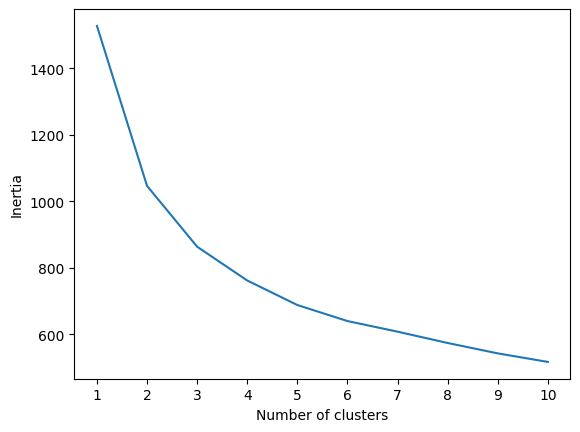

In [18]:
#Raw data
inertia = []
k = [1,2,3,4,5,6,7,8,9,10]


# Looking for the best k
for i in k:
    km = KMeans(n_clusters=i, random_state=0, n_init=10)
    km.fit(scaled_data)
    inertia.append(km.inertia_)

# Define a DataFrame to plot the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)

plt.plot(df_elbow['k'], df_elbow['inertia'])
plt.xticks(range(1,11))
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

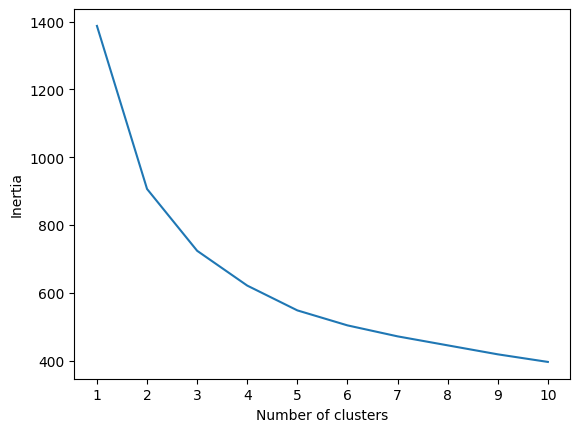

In [19]:
#Raw data
inertia = []
k = [1,2,3,4,5,6,7,8,9,10]


# Looking for the best k
for i in k:
    km = KMeans(n_clusters=i, random_state=0, n_init=10)
    km.fit(pca)
    inertia.append(km.inertia_)

# Define a DataFrame to plot the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)

plt.plot(df_elbow['k'], df_elbow['inertia'])
plt.xticks(range(1,11))
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

## Classifying by group

In [21]:
#Assign features
X_g = df_group[['bodyweight', 'timepoint', 't0', 't15', 't30', 't60', 't90', 't120']]
y_g = df.group
y_g = pd.Series(np.where(y_g.values == 'WT', 1, 0),
          y_g.index)

# Split the data into X_train, X_test, y_train, y_test
X_g_train, X_g_test, y_g_train, y_g_test = train_test_split(X_g, y_g, random_state=1)

In [27]:
#Define classifier to test
g_classifiers = [
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    LogisticRegression(),
    RandomForestClassifier(max_depth=5, n_estimators=100, max_features=1),
    xgb.XGBClassifier(objective="binary:logistic", random_state=1)
]

#setup score df
group_results = pd.DataFrame(columns = ['classifier', 'training_r', 'testing_r', 'MSE', 'MAE', 'accuracy'])

#define a command to run different classification models
def test_g_classifier(classifier):
    model = classifier
    
    #Train model and print results
    model.fit(X_g_train, y_g_train)
    
    y_pred = model.predict(X_g_test)
    mse=mean_squared_error(y_g_test, y_pred)
    mae = mean_absolute_error(y_g_test, y_pred)
    
    print(f'Accuracy: {accuracy_score(y_pred, y_g_test)}')
    print(f'Confusion Matrix: {confusion_matrix(y_pred, y_g_test)}')
        
    #save results to data frame
    group_results.loc[len(group_results.index)] = [str(classifier), model.score(X_g_train, y_g_train), model.score(X_g_test, y_g_test), mse, mae, accuracy_score(y_pred, y_g_test)] 
    
    #print results
    print(str(classifier))
    print(f"Training Data Score: {model.score(X_g_train, y_g_train)}")
    print(f"Testing Data Score: {model.score(X_g_test, y_g_test)}")
    print("--------------------------------")
    
for i in g_classifiers:
    test_g_classifier(i)

Accuracy: 0.5208333333333334
Confusion Matrix: [[ 9  5]
 [18 16]]
SVC(C=0.025, kernel='linear')
Training Data Score: 0.6853146853146853
Testing Data Score: 0.5208333333333334
--------------------------------
Accuracy: 0.4375
Confusion Matrix: [[ 0  0]
 [27 21]]
SVC(C=1, gamma=2)
Training Data Score: 1.0
Testing Data Score: 0.4375
--------------------------------
Accuracy: 0.5208333333333334
Confusion Matrix: [[ 9  5]
 [18 16]]
LogisticRegression()
Training Data Score: 0.7062937062937062
Testing Data Score: 0.5208333333333334
--------------------------------
Accuracy: 0.5416666666666666
Confusion Matrix: [[14  9]
 [13 12]]
RandomForestClassifier(max_depth=5, max_features=1)
Training Data Score: 0.9370629370629371
Testing Data Score: 0.5416666666666666
--------------------------------
Accuracy: 0.5208333333333334
Confusion Matrix: [[13  9]
 [14 12]]
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              cols

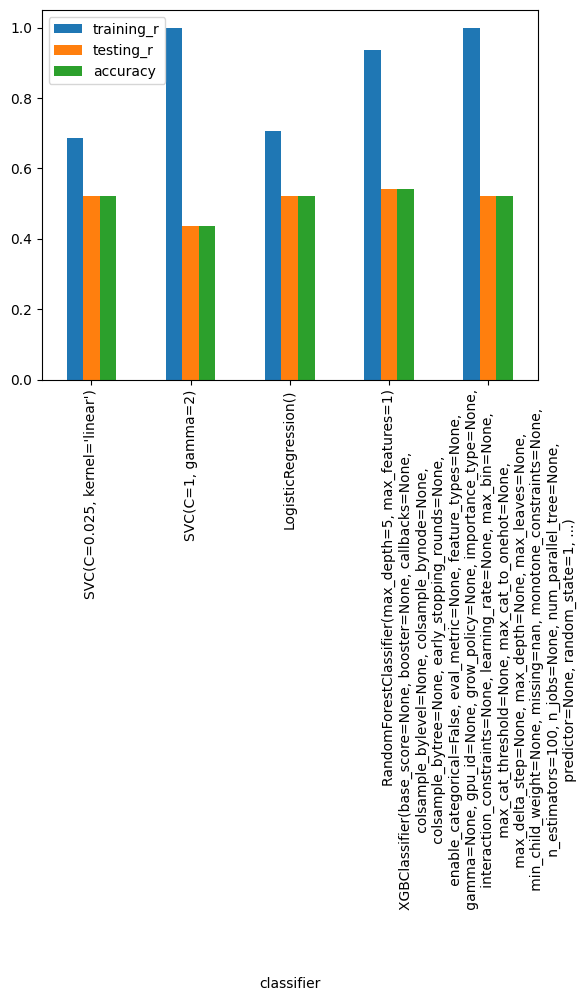

In [30]:
group_results.plot(kind = 'bar', x='classifier', y = ['training_r', 'testing_r', 'accuracy'])
plt.xticks(rotation = 90)
plt.show()

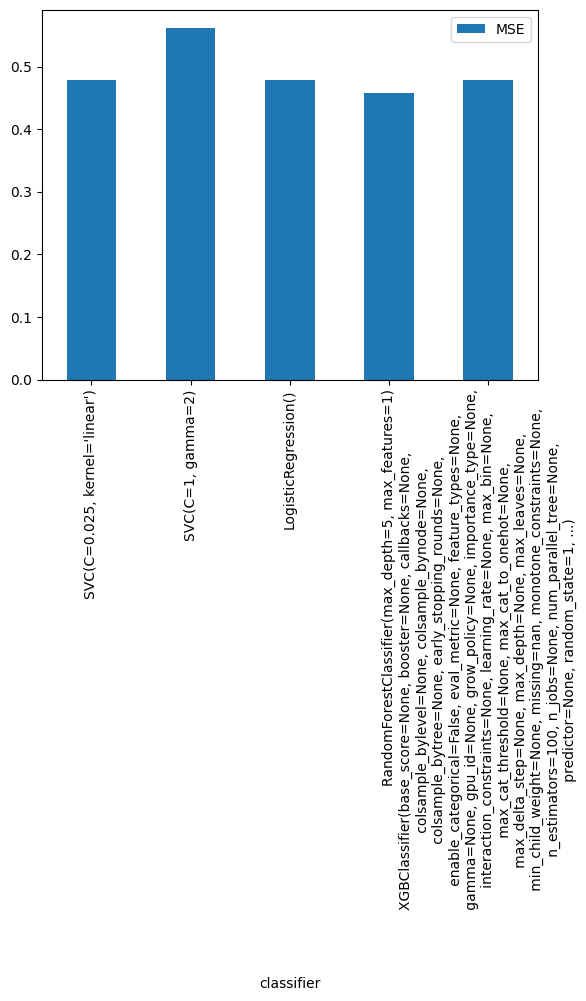

In [31]:
group_results.plot(kind = 'bar', x='classifier', y = ['MSE'])
plt.xticks(rotation = 90)
plt.show()

# Classifying by sex

In [37]:
#Assign features
X_s = df[['bodyweight', 'timepoint', 't0', 't15', 't30', 't60', 't90', 't120']]
y_s = df.sex
y_s = pd.Series(np.where(y_s.values == 'F', 1, 0),
          y_s.index)

# Split the data into X_train, X_test, y_train, y_test
X_s_train, X_s_test, y_s_train, y_s_test = train_test_split(X_s, y_s, random_state=1)

In [40]:
s_classifiers = [
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    LogisticRegression(),
    RandomForestClassifier(max_depth=5, n_estimators=100, max_features=1),
    # xgb.XGBRegressor(objective="reg:linear", random_state=1)
]

#setup score df
s_results = pd.DataFrame(columns = ['classifier', 'training_r', 'testing_r', 'MSE', 'MAE'])

#define a command to run different classification models
def test_s_classifier(classifier):
    model = classifier
    
    #Train model and print results
    model.fit(X_s_train, y_s_train)
    
    #get some prediction metrics
    y_pred = model.predict(X_s_test)
    mse=mean_squared_error(y_s_test, y_pred)
    mae = mean_absolute_error(y_s_test, y_pred)
    
    print(f'Accuracy: {accuracy_score(y_pred, y_s_test)}')
    print(f'Confusion Matrix: {confusion_matrix(y_pred, y_s_test)}')
    
    #save results to data frame
    s_results.loc[len(s_results.index)] = [str(classifier), model.score(X_s_train, y_s_train), model.score(X_s_test, y_s_test), mse, mae] 
    
    #print results
    print(str(classifier))
    print(f"Training Data Score: {model.score(X_s_train, y_s_train)}")
    print(f"Testing Data Score: {model.score(X_s_test, y_s_test)}")
    print("--------------------------------")

for i in s_classifiers:
    test_s_classifier(i)

Accuracy: 0.8333333333333334
Confusion Matrix: [[19  4]
 [ 4 21]]
SVC(C=0.025, kernel='linear')
Training Data Score: 0.8461538461538461
Testing Data Score: 0.8333333333333334
--------------------------------
Accuracy: 0.5208333333333334
Confusion Matrix: [[ 0  0]
 [23 25]]
SVC(C=1, gamma=2)
Training Data Score: 1.0
Testing Data Score: 0.5208333333333334
--------------------------------
Accuracy: 0.8958333333333334
Confusion Matrix: [[20  2]
 [ 3 23]]
LogisticRegression()
Training Data Score: 0.8251748251748252
Testing Data Score: 0.8958333333333334
--------------------------------
Accuracy: 0.9583333333333334
Confusion Matrix: [[22  1]
 [ 1 24]]
RandomForestClassifier(max_depth=5, max_features=1)
Training Data Score: 0.972027972027972
Testing Data Score: 0.9583333333333334
--------------------------------


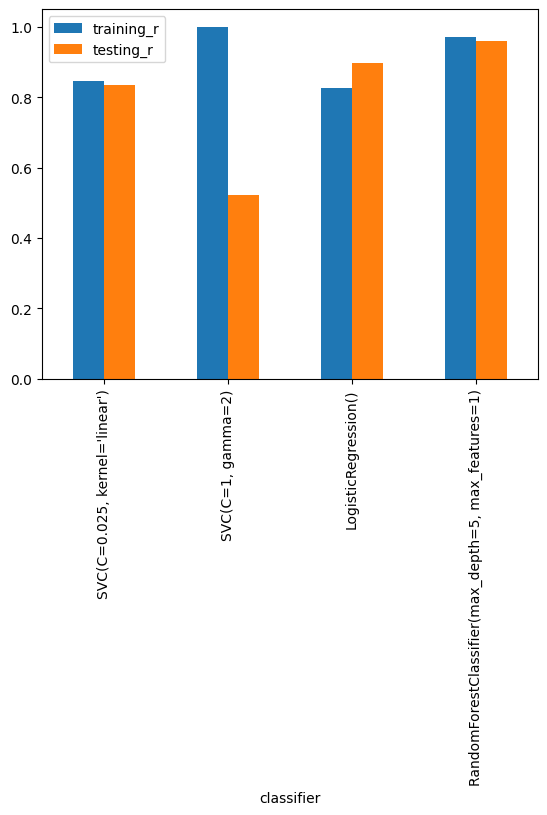

In [41]:
s_results.plot(kind = 'bar', x='classifier', y = ['training_r', 'testing_r'])
plt.xticks(rotation = 90)
plt.show()

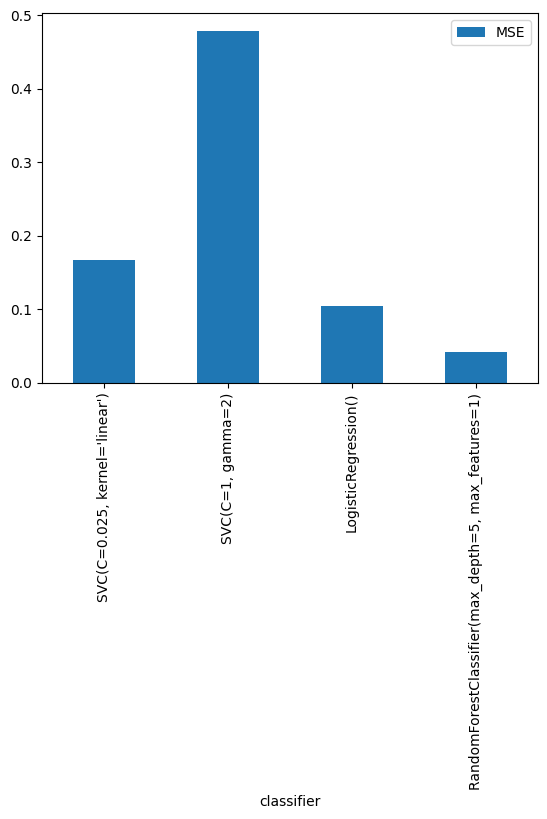

In [42]:
s_results.plot(kind = 'bar', x='classifier', y = ['MSE'])
plt.xticks(rotation = 90)
plt.show()